# Исследование влияния значений гиперпараметров на метрики качества обученной нейронной сети

**Проведите серию экспериментов по перебору гиперпараметров нейронной сети, созданной на занятии.**

1. Поменяйте количество нейронов в сети, используя следующие значения:

    - один слой 10 нейронов
    - один слой 100 нейронов
    - один слой 5000 нейронов

2. Поменяйте активационную функцию в скрытых слоях с `relu` на `linear`.

3. Поменяйте размеры `batch_size`:

    - 1
    - 10
    - 100
    - Вся база (60000)

4. Запишите в таблицу получившиеся точности.

5. Напишите выводы по результатам проведенных тестов.

In [1]:
from pathlib import Path
from typing import Any, Tuple

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import utils

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

Количество эпох обучения:

In [3]:
EPOCHS = 15

Метрики качества:

In [4]:
precision = Precision()
recall = Recall()

Создать датафрейм для хранения результатов тестирования.

In [5]:
report = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([], names=("Категория", "Значение")),
    columns=['loss', 'accuracy', 'precision', 'recall', 'f1']
)

## Подготовка данных

Загрузка данных MNIST

In [6]:
(x_train_org, y_train_org), (x_test_org, y_test_org) =\
    mnist.load_data()

In [7]:
print(x_train_org.shape)

(60000, 28, 28)


Контрольное отображение цифр из набора

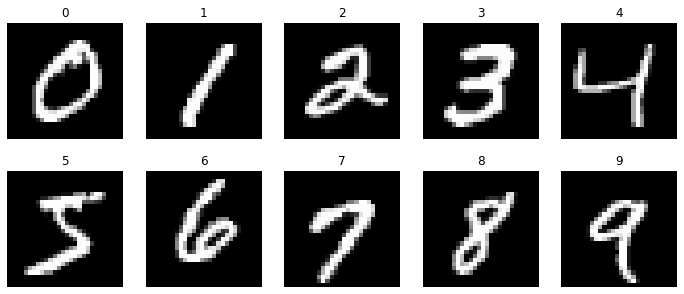

In [8]:
digits = np.unique(y_train_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_train_org[y_train_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений

In [9]:
x_train = x_train_org.reshape(-1, 28*28).astype(np.float32) / 255
x_test = x_test_org.reshape(-1, 28*28).astype(np.float32) / 255

Преобразовать ответы в унитарный код (one-hot)

In [10]:
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [11]:
print(y_train.shape)

(60000, 10)


## Создание модели нейронной сети.

Определение вспомогательного класса для создания модели нейронной сети.

In [12]:
class NetBuilder:

    @staticmethod
    def build(layers: Tuple[int, ...], activation: str='relu') -> Sequential:
        if not layers or not isinstance(layers, Iterable):
            raise RuntimeError(f"Illegal layers collection {layers}")

        model = Sequential()
        # Добавить скрытые слои нейронной сети
        for i, n in enumerate(layers):
            if i == 0:
                layer = Dense(
                    n, input_dim=28*28, activation=activation
                )
            else:
                layer = Dense(
                    n, activation=activation
                )
            model.add(layer)

        # Добавить выходной слой нейронной сети
        model.add(
            Dense(10, activation='softmax')
        )

        return model

## 1. Проверка влияния числа нейронов

### 1.1. 10 нейронов в скрытом слое

Создание модели нейронной сети с 10 нейронами в скрытом слое.

In [13]:
model_n10 = NetBuilder.build(layers=(800, 10))
model_n10.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n10.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 636,120
Trainable params: 636,120
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [14]:
history_n10 = model_n10.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 4s 8ms/step - loss: 0.4291 - accuracy: 0.8658 - precision: 0.9500 - recall: 0.8113
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1175 - accuracy: 0.9657 - precision: 0.9738 - recall: 0.9595
Epoch 3/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0774 - accuracy: 0.9779 - precision: 0.9825 - recall: 0.9737
Epoch 4/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0537 - accuracy: 0.9844 - precision: 0.9876 - recall: 0.9820
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0378 - accuracy: 0.9888 - precision: 0.9908 - recall: 0.9873
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0284 - accuracy: 0.9911 - precision: 0.9924 - recall: 0.9899
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0209 - accuracy: 0.9942 - precision: 0.9949 - recall: 0.9936
Epoch 8/15
469/469 [=====================

Отобразить изменение loss и метрик качества в процессе обучения.

In [15]:
def plot_history(history: History):
    _, axes = plt.subplots(2, 2, figsize=(12, 12))

    axes = axes.flatten()

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue'
    )
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon'
    )
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)

    axes[2].plot(
        history.epoch,
        history.history['precision'],
        color='seagreen'
    )
    axes[2].set_ylabel('precision')
    axes[2].set_xlabel('epoch')
    axes[2].grid(True)

    axes[3].plot(
        history.epoch,
        history.history['recall'],
        color='forestgreen'
    )
    axes[3].set_ylabel('recall')
    axes[3].set_xlabel('epoch')
    axes[3].grid(True)

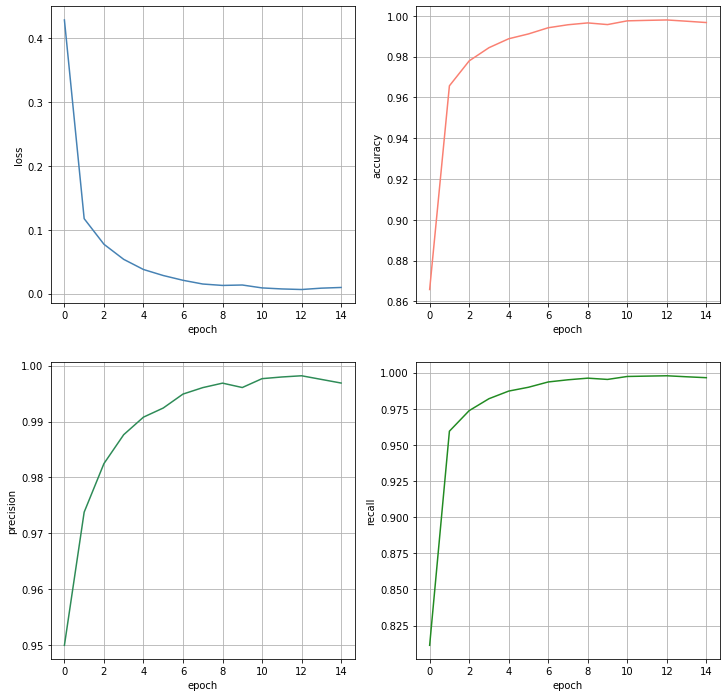

In [16]:
plot_history(history_n10)
plt.show();

Сохранить и загрузить веса нейронной сети

In [17]:
path = Path.home() / 'aiu-01-mnist-light-model_n10.h5'

model_n10.save_weights(path)
model_n10.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [18]:
def update_report(model: Sequential, category: str, value: Any):
    score = model.evaluate(x_test, y_test, verbose=0)

    print(f"\nTest score: {score[0]}")
    print(f"Test accuracy: {score[1]}")
    print(f"Test precision: {score[2]}")
    print(f"Test recall: {score[3]}\n")

    report.loc[(category, value), :] = (
        score[0],
        score[1],
        score[2],
        score[3],
        2 * score[2] * score[3] / (score[2] + score[3])
    )

    y_pred_org = np.argmax(
        model.predict(x_test, verbose=0),
        axis=-1
    )
    print(classification_report(y_test_org, y_pred_org))

In [19]:
update_report(model_n10, "Число нейронов", 10)


Test score: 0.09463558346033096
Test accuracy: 0.9799000024795532
Test precision: 0.9808751344680786
Test recall: 0.9796000123023987

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.96      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 1.2. 100 нейронов в скрытом слое

Создание модели нейронной сети с 100 нейронами в скрытом слое.

In [20]:
model_n100 = NetBuilder.build(layers=(800, 100))
model_n100.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n100.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               80100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 709,110
Trainable params: 709,110
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [21]:
history_n100 = model_n100.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 4s 9ms/step - loss: 0.2185 - accuracy: 0.9344 - precision: 0.9591 - recall: 0.9235
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0811 - accuracy: 0.9757 - precision: 0.9799 - recall: 0.9725
Epoch 3/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0514 - accuracy: 0.9840 - precision: 0.9861 - recall: 0.9821
Epoch 4/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0332 - accuracy: 0.9890 - precision: 0.9904 - recall: 0.9880
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0256 - accuracy: 0.9918 - precision: 0.9925 - recall: 0.9911
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0211 - accuracy: 0.9930 - precision: 0.9937 - recall: 0.9923
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0168 - accuracy: 0.9947 - precision: 0.9949 - recall: 0.9944
Epoch 8/15
469/469 [=====================

Отобразить изменение loss и метрик качества в процессе обучения.

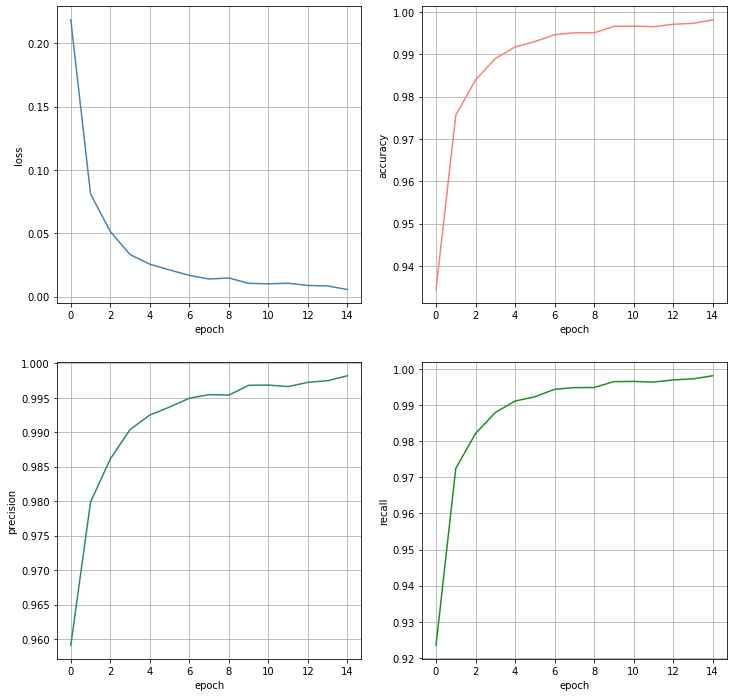

In [22]:
plot_history(history_n100)
plt.show();

Сохранить и загрузить веса нейронной сети

In [23]:
path = Path.home() / 'aiu-01-mnist-light-model_n100.h5'

model_n100.save_weights(path)
model_n100.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [24]:
update_report(model_n100, "Число нейронов", 100)


Test score: 0.08738861978054047
Test accuracy: 0.9824000000953674
Test precision: 0.9828863143920898
Test recall: 0.9821000099182129

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 1.3. 5000 нейронов в скрытом слое

Создание модели нейронной сети с 5000 нейронами в скрытом слое.

In [25]:
model_n5000 = NetBuilder.build(layers=(800, 5000))
model_n5000.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', precision, recall]
)

print(model_n5000.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_7 (Dense)              (None, 5000)              4005000   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                50010     
Total params: 4,683,010
Trainable params: 4,683,010
Non-trainable params: 0
_________________________________________________________________
None


Обучение нейронной сети.

In [26]:
history_n5000 = model_n5000.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
469/469 [==============================] - 27s 58ms/step - loss: 0.1839 - accuracy: 0.9443 - precision: 0.9627 - recall: 0.9395
Epoch 2/15
469/469 [==============================] - 28s 59ms/step - loss: 0.0748 - accuracy: 0.9771 - precision: 0.9800 - recall: 0.9741
Epoch 3/15
469/469 [==============================] - 28s 59ms/step - loss: 0.0500 - accuracy: 0.9843 - precision: 0.9858 - recall: 0.9829
Epoch 4/15
469/469 [==============================] - 29s 61ms/step - loss: 0.0389 - accuracy: 0.9869 - precision: 0.9881 - recall: 0.9860
Epoch 5/15
469/469 [==============================] - 29s 61ms/step - loss: 0.0321 - accuracy: 0.9900 - precision: 0.9908 - recall: 0.9893
Epoch 6/15
469/469 [==============================] - 30s 63ms/step - loss: 0.0247 - accuracy: 0.9917 - precision: 0.9922 - recall: 0.9911
Epoch 7/15
469/469 [==============================] - 30s 64ms/step - loss: 0.0236 - accuracy: 0.9922 - precision: 0.9928 - recall: 0.9918
Epoch 8/15
469/469 [=======

Отобразить изменение loss и метрик качества в процессе обучения.

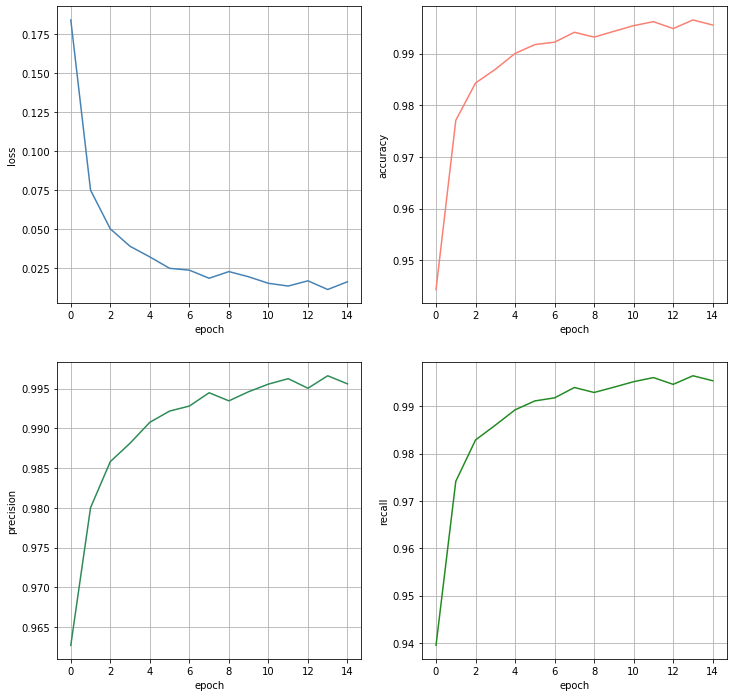

In [27]:
plot_history(history_n5000)
plt.show();

Сохранить и загрузить веса нейронной сети

In [28]:
path = Path.home() / 'aiu-01-mnist-light-model_n5000.h5'

model_n5000.save_weights(path)
model_n5000.load_weights(path)

Оценить loss и метрики качества на тестовой выборке.

In [29]:
update_report(model_n5000, "Число нейронов", 5000)


Test score: 0.08594612777233124
Test accuracy: 0.9818999767303467
Test precision: 0.982782781124115
Test recall: 0.9818000197410583

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 2. Замена функции активации